In [1]:
import pydicom
import pylab
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
from tqdm import tqdm
from time import sleep
from sklearn import decomposition
from numba import jit
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import lit


import random

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

from pyspark.ml.feature import OneHotEncoder as OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.recommendation import ALS
from pyspark.mllib.recommendation import MatrixFactorizationModel, Rating
from pyspark.sql.session import SparkSession
from pyspark.sql.types import IntegerType
import pyspark
import findspark
from pyspark import SparkConf,SparkContext
from pyspark.ml.evaluation import RegressionEvaluator
findspark.init()
sc = SparkContext('local')
spark = SparkSession(sc)

In [47]:
train_dir = os.path.join("D:\\learning material\\EE695\\Final Project\\project images\\Lung-PET-CT-Dx\\Lung_Dx-A0001\\04-04-2007-Chest-07990\\2.000000-5mm-40805")
label_dir = os.path.join("D:\\learning material\\EE695\\Final Project\\project images\\Annotation")
print(train_dir)

D:\learning material\EE695\Final Project\project images\Lung-PET-CT-Dx\Lung_Dx-A0001\04-04-2007-Chest-07990\2.000000-5mm-40805


In [48]:
train_image_names = os.listdir(train_dir)
train_labels_names = os.listdir(label_dir)

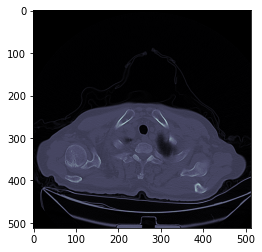

In [49]:
ds = pydicom.read_file(train_dir+"\\" + train_image_names[8])
pix = ds.pixel_array

pylab.imshow(pix, cmap=pylab.cm.bone)
pylab.show()

In [50]:
def list_with_no_hidden(path):
    os_list = os.listdir(path)
    for item in os_list:
        if item.startswith('.') and os.path.isfile(os.path.join(path, item)):
            os_list.remove(item)
    return os_list

In [51]:
cancer_dict={
    'A':0,
    'B':1,
    'E':2,
    'G':3,
}

In [52]:
data_dir = 'D:\\learning material\\EE695\\Final Project\\project images\\Lung-PET-CT-Dx'
classes=list_with_no_hidden(data_dir)

In [53]:
data = []
X_array = []
Y_array = []
for cls in tqdm(classes):
    Chests = list_with_no_hidden(data_dir+'\\'+cls)
    result_type = cancer_dict[cls[8]]####<--------------------cancer type
    for chest in Chests:
        File = list_with_no_hidden(data_dir+'\\'+cls+"\\"+chest)
        for file in File:
            Img = list_with_no_hidden(data_dir+'\\'+cls+"\\"+chest+'\\'+file)
            for img in Img:
                ds = pydicom.read_file(data_dir+'\\'+cls+"\\"+chest+"\\"+file+"\\"+img)
                pix = ds.pixel_array
                pix_reshape = pix.reshape(pix.shape[0]*pix.shape[1], )   
        
                pix_array = np.append(pix_reshape, result_type)
                
                pix_reshape = np.array(pix_reshape)
                result_type = np.array(result_type)
                #data.append(pix_array)
                X_array.append(pix_reshape)
                Y_array.append(result_type)
    #sleep(0.5)

100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


In [54]:
X_array = np.array(X_array)
Y_array = np.array(Y_array)
print(X_array.shape)
print(Y_array.shape)

(2739, 262144)
(2739,)


In [55]:
def red_dim(X):
    pca = decomposition.PCA(n_components=144, svd_solver='randomized', whiten=True)
    pca.fit(X)
    return pca

In [56]:
pca = red_dim(X_array)

In [57]:
X_train,X_test,y_train,y_test=train_test_split(X_array,Y_array,test_size=0.3,random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

1917 822 1917 822


In [58]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [59]:
feat_cols = [ 'pixel'+str(i) for i in range (144) ]
pd_train_X=pd.DataFrame(X_train_pca,columns=feat_cols)
pd_test_X=pd.DataFrame(X_test_pca,columns=feat_cols)
pd_train_y=pd.DataFrame(y_train,columns=['type'])
pd_test_y=pd.DataFrame(y_test,columns=['type'])

In [18]:
train= pd.concat([pd_train_X, pd_train_y], axis=1, join='inner')
test = pd.concat([pd_test_X, pd_test_y], axis=1, join='inner')
#train.to_csv('train_set.csv', index =False)
#test.to_csv('test_set.csv', index =False)
data = pd.concat([train,test],axis=0,join='inner')
data.to_csv('695data.csv',index=False)

In [2]:
spark = SparkSession.builder.appName('ml-test').getOrCreate()
train = spark.read.csv('695data.csv',header = True, inferSchema = True)

In [3]:
assembler = VectorAssembler(inputCols=["pixel0", "pixel1", "pixel2", "pixel3", "pixel4", "pixel5", "pixel6", "pixel7", "pixel8", "pixel9", "pixel10", "pixel11", "pixel12", "pixel13", "pixel14", "pixel15", "pixel16", "pixel17", "pixel18", "pixel19", "pixel20", "pixel21", "pixel22", "pixel23", "pixel24", "pixel25", "pixel26", "pixel27", "pixel28", "pixel29", "pixel30", "pixel31", "pixel32", "pixel33","pixel34", "pixel35", "pixel36", "pixel37", "pixel38", "pixel39", "pixel40", "pixel41", "pixel42", "pixel43", "pixel44", "pixel45", "pixel46", "pixel47", "pixel48", "pixel49", "pixel50", "pixel51", "pixel52", "pixel53", "pixel54", "pixel55", "pixel56", "pixel57", "pixel58", "pixel59", "pixel60", "pixel61", "pixel62", "pixel63", "pixel64", "pixel65", "pixel66", "pixel67", "pixel68", "pixel69", "pixel70", "pixel71", "pixel72", "pixel73", "pixel74", "pixel75", "pixel76", "pixel77", "pixel78", "pixel79", "pixel80", "pixel81", "pixel82", "pixel83", "pixel84", "pixel85", "pixel86", "pixel87", "pixel88", "pixel89", "pixel90", "pixel91", "pixel92", "pixel93", "pixel94", "pixel95", "pixel96", "pixel97", "pixel98", "pixel99", "pixel100", "pixel101", "pixel102", "pixel103", "pixel104", "pixel105", "pixel106", "pixel107", "pixel108", "pixel109", "pixel110", "pixel111", "pixel112", "pixel113", "pixel114", "pixel115", "pixel116", "pixel117", "pixel118", "pixel119", "pixel120", "pixel121", "pixel122", "pixel123", "pixel124", "pixel125", "pixel126", "pixel127", "pixel128", "pixel129", "pixel130", "pixel131", "pixel132", "pixel133", "pixel134", "pixel135", "pixel136", "pixel137", "pixel138", "pixel139", "pixel140", "pixel141", "pixel142", "pixel143"], outputCol="features")

In [4]:
train = assembler.transform(train)

In [11]:
train1, test1 = train.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(train1.count()))
print("Testing Dataset Count: " + str(test1.count()))

Training Dataset Count: 1913
Testing Dataset Count: 826


In [6]:
lr = LogisticRegression(featuresCol = "features", labelCol ='type', maxIter=10)
lrModel = lr.fit(train1)

In [36]:
lrtest = lrModel.transform(test1)
#lrtest.head()

In [45]:
print('{}{}'.format('accuracy：',lrModel.evaluate(test1).accuracy) )

accuracy：0.9988165680473373


In [46]:
lrtest.toPandas().to_csv('LogisticRegression.csv', index =False)

In [12]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'type',maxDepth = 8)
dtModel = dt.fit(train1)

In [13]:
dttest = dtModel.transform(test1)

In [14]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluatorClassifier = MulticlassClassificationEvaluator().setLabelCol("type").setPredictionCol("prediction").setMetricName("accuracy")
accuracy = evaluatorClassifier.evaluate(dttest)
print("accuracy = " + str(accuracy))

accuracy = 0.9806295399515739


In [16]:
dttest.toPandas().to_csv('DecisionTree.csv', index =False)

In [63]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'type')
rfModel = rf.fit(train1)

In [64]:
rftest = rfModel.transform(test1)

In [65]:
evaluatorClassifier = MulticlassClassificationEvaluator().setLabelCol("type").setPredictionCol("prediction").setMetricName("accuracy")
accuracy = evaluatorClassifier.evaluate(rftest)
print("accuracy = " + str(accuracy))

accuracy = 0.9633136094674556


In [ ]:
rftest.toPandas().to_csv('RandomForest.csv', index =False)